In [1]:
import pysam
import vcf
from joblib import delayed,Parallel

In [2]:
import numpy as np

In [3]:
from collections import Counter

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
def get_allele_counts_per_cell(bamfile, variant, cell_set):
    bam = pysam.AlignmentFile(bamfile, 'r')
    ref_counter = {}
    alt_counter = {}
    variant_pos = variant.POS-1
    name = '{}:{}_{}>{}'.format(variant.CHROM, variant.POS, variant.REF, variant.ALT[0])
    for read in bam.fetch(variant.CHROM, variant.POS-10,variant.POS+10):
        cell = read.get_tag('BC')
        if cell not in cell_set:
            continue
        reference_positions = read.get_reference_positions()
        read_sequence = read.query_alignment_sequence
        pos_to_base_dict = {pos:base for pos,base in zip(reference_positions, read_sequence)}
        if variant_pos in pos_to_base_dict:
            if pos_to_base_dict[variant_pos] == variant.REF:
                if cell in ref_counter:
                    ref_counter[cell] += 1
                else:
                    ref_counter.update({cell:1})
            elif pos_to_base_dict[variant_pos] == variant.ALT[0]:
                if cell in alt_counter:
                    alt_counter[cell] += 1
                else:
                    alt_counter.update({cell:1})
    bam.close()
    return name, ref_counter, alt_counter

In [7]:
import pandas as pd

In [89]:
#bamfile = '/home/antonl/projects/XAlgo/F1_Fibro/Fibro_plate3.chrX.sorted.bam'
bamfile = '/home/michaelhj/projects/smartseq3/Smartseq2_Fibroblasts_Anton_rerun/zUMIs/Smartseq3_Fibroblasts.filtered.Aligned.GeneTagged.UBcorrected.sorted.bam'
vcffile = '/home/chrisz/resources/genomes/Mouse/CAST.SNPs.validated.passedFiltering.vcf.gz'

In [47]:
#cell_file = '/home/chrisz/proj/DNBseq_evaluation/plate3_expected_bcs.txt'
cell_file = '/home/michaelhj/projects/smartseq3/Smartseq2_Fibroblasts_Anton_rerun/expected_barcodes.txt'

In [48]:
cell_set = set([cell.rstrip('\n') for cell in open(cell_file, 'r')])

In [90]:
vcf_reader = vcf.Reader(filename=vcffile)

In [91]:
variant_list = []
for variant in vcf_reader.fetch('chrX'):
    variant_list.append(variant)

In [93]:
for i,variant in enumerate(variant_list):
    if variant.POS == 5206611:
        print(i,variant)

In [94]:
len(variant_list)

40048

In [95]:
variant_dict = {'{}:{}_{}>{}'.format(variant.CHROM, variant.POS, variant.REF, variant.ALT[0]): variant for variant in variant_list}

In [96]:
res = Parallel(n_jobs=40, verbose=3)(delayed(get_allele_counts_per_cell)(bamfile, variant, cell_set) for variant in variant_list)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  49 tasks      | elapsed:    7.4s
[Parallel(n_jobs=40)]: Done 209 tasks      | elapsed:    7.9s
[Parallel(n_jobs=40)]: Done 433 tasks      | elapsed:    8.6s
[Parallel(n_jobs=40)]: Done 721 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 1073 tasks      | elapsed:   10.7s
[Parallel(n_jobs=40)]: Done 1489 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 1969 tasks      | elapsed:   13.5s
[Parallel(n_jobs=40)]: Done 2513 tasks      | elapsed:   15.2s
[Parallel(n_jobs=40)]: Done 3121 tasks      | elapsed:   17.1s
[Parallel(n_jobs=40)]: Done 3793 tasks      | elapsed:   19.3s
[Parallel(n_jobs=40)]: Done 4529 tasks      | elapsed:   21.8s
[Parallel(n_jobs=40)]: Done 5329 tasks      | elapsed:   24.4s
[Parallel(n_jobs=40)]: Done 6193 tasks      | elapsed:   27.3s
[Parallel(n_jobs=40)]: Done 7402 tasks      | elapsed:   30.3s
[Parallel(n_jobs=40)]: Done 9386 tasks      |

In [97]:
variant_counts = {r[0]: (r[1], r[2]) for r in res if len(r[1]) != 0 and len(r[2]) != 0}

In [ ]:
#old code please ignore
#variant_counts = {}
#for i, variant in enumerate(variant_list): 
#    res = get_allele_counts_per_cell(bamfile, variant, cell_set)
#    if len(res[1]) == 0 and len(res[2]) == 0:
#        continue
#    variant_counts[res[0]] = (res[1], res[2])

In [98]:
variant_counts_both_alleles_detected = {}
for var_name, tup in variant_counts.items():
    if len(tup[0]) > 0 and len(tup[1]) > 0:
        variant_counts_both_alleles_detected[var_name] = tup

In [99]:
alt_counter = Counter()
ref_counter = Counter()
for var_name, tup in variant_counts_both_alleles_detected.items():
    ref_counter.update(tup[0])
    alt_counter.update(tup[1])

In [100]:
ref_count_df = pd.DataFrame.from_dict({k:t[0] for k,t in variant_counts_both_alleles_detected.items()}, orient='index')

In [101]:
alt_count_df = pd.DataFrame.from_dict({k:t[1] for k,t in variant_counts_both_alleles_detected.items()}, orient='index')

In [102]:
ref_count_df = ref_count_df.fillna(0)

In [103]:
alt_count_df = alt_count_df.fillna(0)

In [106]:
df_test = pd.DataFrame([ref_counter, alt_counter], index=['ref', 'alt']).T.fillna(0)

In [123]:
vireo_df = pd.read_csv('/home/antonl/projects/XAlgo/F1_Fibro_from_SS3_paper/vireo_out/donor_ids.tsv', sep='\t', index_col=0)

In [125]:
vireo_df.groupby('donor_id').count()

,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
donor_id,,,,,,
donor0,53,53,53,53,53,53
donor1,188,188,188,188,188,188
unassigned,46,46,46,46,46,46


In [126]:
df_test = df_test.join(vireo_df['donor_id'])

In [127]:
df_test = df_test.join(vireo_df['n_vars'])

In [129]:
df_test['total'] = df_test['ref']+df_test['alt']

In [130]:
df_test['fraction_ref'] = df_test['ref']/df_test['total']

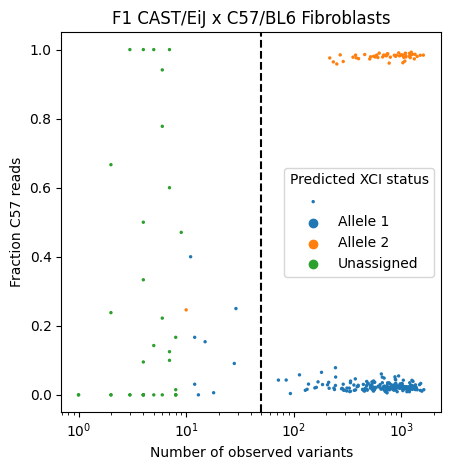

In [161]:
fig, ax = plt.subplots(1,1)
g = sns.scatterplot(data=df_test, x='n_vars', hue='donor_id',y='fraction_ref', s=6,ax=ax, linewidth=0)
ax.legend(title='Predicted XCI status', loc='best', labels=['','Allele 1', 'Allele 2','Unassigned'])
ax.axvline(50, linestyle='dashed', color='black')
ax.set_xscale('log')
ax.set_title('F1 CAST/EiJ x C57/BL6 Fibroblasts')
ax.set_xlabel('Number of observed variants')
ax.set_ylabel('Fraction C57 reads')
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Fig1C.pdf')
plt.show()